# Sparkify - Predicting User Churn

Sparkify is a fictional music streaming service similar to Spotify, with a free-tier supported by advertisements and a monthly subscription service. Predicting user churn enables them to target users who are considering leaving Sparkify and offering  special discounts or services to retain these users and maximize profit.

This code will use data about user interactions to create features that could be predictive of which users will churn, and then train and evaluate models for this prediction task.

## 1. PySpark Setup

In [27]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import udf, desc, when, col
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import max as Fmax, sum as Fsum

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
os.environ['PYSPARK_PYTHON'] = 'python'

In [2]:
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

## 2. Load and Clean Dataset

In [3]:
#Read event data from mini file
path = "data/mini_sparkify_event_data.json"
sparkify_event_log = spark.read.json(path)

sparkify_event_log.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
sparkify_event_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
#Check for any rows with a missing sessionId - these would likely be a data error within the Sparkify system
sparkify_event_log.filter(sparkify_event_log['sessionId'] == '').count()
#There are no rows which are missing a sessionId so no cleaning need to address these

0

In [6]:
#Check for any rows with a missing userId - these won't be useful to predict user churn
sparkify_event_log.filter(sparkify_event_log['userId'] == "").count()

8346

In [7]:
sparkify_event_log.filter(sparkify_event_log['userId'] == "").select(sparkify_event_log['page']).distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



There are many rows without a userId. Looking at the events these relate to, they relate to Sparkify information pages such as Home, About and Help. It makes sense that these pages would be accessed by logged out or guest users so we can drop them from this dataset as they won't be useful for predicting churn.

In [8]:
user_event_log = sparkify_event_log.filter(sparkify_event_log['userId'] != "")
user_event_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

## 3. Exploratory Data Analysis

In [9]:
#Count number of unique users
user_event_log.select("userId").dropDuplicates().count()

225

In [10]:
#Investigate page column
page_counts = user_event_log.groupby(user_event_log.page).count().orderBy('count', ascending=False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



From this we can see that the majority of events correspond to playing songs, which makes sense for a music streaming service. Some of the other common events such as Thumbs Up, Add to Playlist or Roll Advert could be used to create predictive features.
The other key event here is the Cancel Confirmation page, which will be used to define user churn.

In [11]:
# Check for any other columns with null values
null_counts = {col:user_event_log.filter(user_event_log[col].isNull()).count() for col in user_event_log.columns}
null_counts 
#The only remaining null values are for artist, song, and length 
#these correspond to rows where the event is not listening to song

{'artist': 50046,
 'auth': 0,
 'firstName': 0,
 'gender': 0,
 'itemInSession': 0,
 'lastName': 0,
 'length': 50046,
 'level': 0,
 'location': 0,
 'method': 0,
 'page': 0,
 'registration': 0,
 'sessionId': 0,
 'song': 50046,
 'status': 0,
 'ts': 0,
 'userAgent': 0,
 'userId': 0}

### Create user churn flag

In [12]:
#Create CHURN flag using user-defined function
create_churn_flag = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
user_event_log = user_event_log.withColumn("ChurnFlag", create_churn_flag("page"))

user_event_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ChurnFlag=0)

In [13]:
user_event_log.groupBy('ChurnFlag').count().show()

+---------+------+
|ChurnFlag| count|
+---------+------+
|        1|    52|
|        0|278102|
+---------+------+



There were only 52 cancellation events out of the 278k rows - fortunately for Sparkify it looks like user churn is a very rare event. Since we're interested in predicting which users will churn, we next need to flag all rows belonging to a churn user. We can do this by using a Window function to find the maximum value of ChurnFlag for each user and attach this to all their other log entries.

In [14]:
#create a window based on userId and sorted by event timestamp
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [15]:
user_event_log = user_event_log.withColumn("ChurnUser", Fmax("ChurnFlag").over(windowval))
user_event_log.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', ChurnFlag=0, ChurnUser=0)

In [16]:
user_event_log.groupBy('ChurnUser').count().show()
user_event_log.select('userId','ChurnUser').distinct().groupBy('ChurnUser').count().show()

+---------+------+
|ChurnUser| count|
+---------+------+
|        1| 44864|
|        0|233290|
+---------+------+

+---------+-----+
|ChurnUser|count|
+---------+-----+
|        1|   52|
|        0|  173|
+---------+-----+



From this we can see that nearly a quarter of users have churned, which would not be good for Sparkify's profits! We clearly need to find a way to identify these users before they churn and find strategies to prevent this. We can start by looking at the relationship between our Churn users and other users based on some of the other features in out event log.

In [17]:
users_df = user_event_log.select('userId','gender', 'level','ChurnFlag').distinct().toPandas()

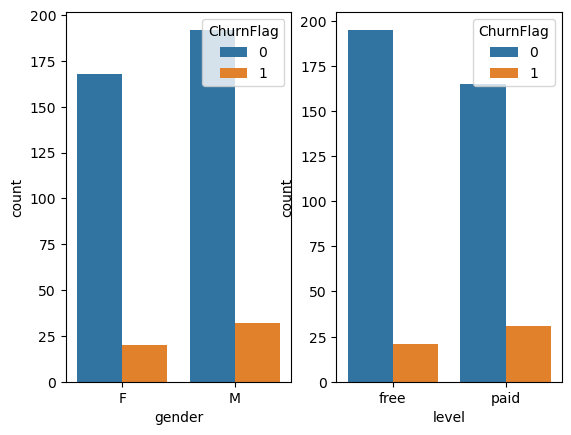

In [18]:
fig, ax =plt.subplots(1,2)
sns.countplot(x='gender', data=users_df, hue='ChurnFlag', ax=ax[0]);
sns.countplot(x='level', data=users_df, hue='ChurnFlag', ax=ax[1]);

## 4. Feature Engineering

Spark machine learning models require the input features to be in numeric form, so we'll focus on creating numeric rather than categorical factors. There are some categorical factors in the input data that can be easily converted to a binary numeric representation, so we will also consider these factors.

In [19]:
#Convert gender and level to binary categorical features
user_event_log = user_event_log.withColumn("gender", when(user_event_log.gender == "M",0) \
      .when(user_event_log.gender == "F",1))

user_event_log = user_event_log.withColumn("level", when(user_event_log.level == "free",0) \
      .when(user_event_log.level == "paid",1))

user_event_log.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender=1, itemInSession=34, lastName='Carpenter', length=None, level=0, location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', ChurnFlag=0, ChurnUser=0)

In [30]:
#create page-view counts per user, using the same approach as we used to create our churn flag
#ignore uninteresting pages such as About or Home
page_dict = {'friend': 'Add Friend', 'thumbs_up': 'Thumbs Up', 'thumbs_down': 'Thumbs Down',
             'upgrade': 'Submit Upgrade', 'downgrade': 'Submit Downgrade', 'song': 'NextSong', 
             'advert': 'Roll Advert', 'error': 'Error', 'playlist': 'Add to Playlist'
}
for key in page_dict.keys():
    udf_page = udf(lambda x: 1 if x == page_dict[key] else 0, IntegerType())
    user_event_log = user_event_log.withColumn('p_' + key, udf_page("page"))

#Check each page type has been set correctly
user_event_log.select('page',user_event_log.colRegex("`(p_)+?.+`")).distinct().show()


+--------------------+--------+-----------+-------------+---------+-----------+------+--------+-------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|                page|p_friend|p_thumbs_up|p_thumbs_down|p_upgrade|p_downgrade|p_song|p_advert|p_error|p_playlist|p_p_thumbs_up|p_p_thumbs_down|p_p_upgrade|p_p_downgrade|p_p_song|p_p_advert|p_p_error|p_p_playlist|
+--------------------+--------+-----------+-------------+---------+-----------+------+--------+-------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|     Add to Playlist|       0|          0|            0|        0|          0|     0|       0|      0|         1|            0|              0|          0|            0|       0|         0|        0|           1|
|                Home|       0|          0|            0|        0|          0|     0|       0|      0|         0|            0|              0|

In [37]:
#Create count variables for each of these page views
#partition the dataframe based on the userId column
user_window = Window.partitionBy("userId")
#return the sum of values for each page type
for key in page_dict:
    user_event_log = user_event_log.withColumn('sum_' + key, Fsum(col('p_' + key)).over(user_window))

#Check first few rows look sensible
user_event_log.select('userId',user_event_log.colRegex("`(sum_)+?.+`")).show(5)

#Check first few rows for unique users
user_event_log.select('userId',user_event_log.colRegex("`(sum_)+?.+`")).distinct().show(5)

+------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|userId|sum_friend|sum_thumbs_up|sum_thumbs_down|sum_upgrade|sum_downgrade|sum_song|sum_advert|sum_error|sum_playlist|
+------+----------+-------------+---------------+-----------+-------------+--------+----------+---------+------------+
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
|100010|         4|           17|              5|          0|            0|     275|        52|        0|           7|
+------+----------+-------------+---------------

## 5. Modelling